# Importing Libraries

In [2]:
# Import libraries

# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# Data saving libraries
import os
import pickle

# General models and analyzers
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
# Scipy
from scipy.stats import randint, uniform
# TQDM (For loop progression)
from tqdm import tqdm
# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim


# Important Constants

In [3]:
numerical_features = ["Danceability", "Energy", "Loudness", "Speechiness", "Acousticness",
                      "Instrumentalness", "Valence" ]
date_features = ["Day", "Month", "Year"]

custom_features = ["Artists_Weight","Weighted_Endurance","Ranking_Derivative"]

# Data Pre-Processing


## Loading Data and Cleaning

In [4]:
# Load data
df_original = pd.read_csv("Spotify_Dataset_V3.csv", sep = ";")

# Clean date and rank columns to a more standard format
df_original["Date"] = pd.to_datetime(df_original["Date"], format="%d/%m/%Y", errors="coerce")
df_original["Rank"] = pd.to_numeric(df_original["Rank"], errors="coerce")

# Scout data's structure
df_original.head()

,Rank,Title,Artists,Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,# of Artist,Artist (Ind.),# of Nationality,Nationality,Continent,Points (Total),Points (Ind for each Artist/Nat),id,Song URL
0,1,Ella Baila Sola,"Eslabon Armado, Peso Pluma",2023-05-29,0.668,0.758,-5176.0,0.033,0.483,0.000,0.834,Artist 1,Eslabon Armado,Nationality 1,Mexico,Latin-America,200,100.0,3qQbCzHBycnDpGskqOWY0E,https://open.spotify.com/track/3qQbCzHBycnDpGs...
1,1,Ella Baila Sola,"Eslabon Armado, Peso Pluma",2023-05-29,0.668,0.758,-5176.0,0.033,0.483,0.000,0.834,Artist 2,Peso Pluma,Nationality 2,Mexico,Latin-America,200,100.0,3qQbCzHBycnDpGskqOWY0E,https://open.spotify.com/track/3qQbCzHBycnDpGs...
2,2,WHERE SHE GOES,Bad Bunny,2023-05-29,0.652,0.800,-4019.0,0.061,0.143,0.629,0.234,Artist 1,Bad Bunny,Nationality 1,Puerto Rico,Latin-America,199,199.0,7ro0hRteUMfnOioTFI5TG1,https://open.spotify.com/track/7ro0hRteUMfnOio...
3,3,La Bebe - Remix,"Yng Lvcas, Peso Pluma",2023-05-29,0.812,0.479,-5678.0,0.333,0.213,0.000,0.559,Artist 1,Yng Lvcas,Nationality 1,Mexico,Latin-America,198,99.0,2UW7JaomAMuX9pZrjVpHAU,https://open.spotify.com/track/2UW7JaomAMuX9pZ...
4,3,La Bebe - Remix,"Yng Lvcas, Peso Pluma",2023-05-29,0.812,0.479,-5678.0,0.333,0.213,0.000,0.559,Artist 2,Peso Pluma,Nationality 2,Mexico,Latin-America,198,99.0,2UW7JaomAMuX9pZrjVpHAU,https://open.spotify.com/track/2UW7JaomAMuX9pZ...


## Cleaning data and preparing for training dataset

In [5]:
# make a copy of df
dfMod = df_original.copy()

# remove duplicate entries
dfMod = dfMod.sort_values(by=["Title", "Date"]).drop_duplicates(
    subset=["Title", "Date"],
    keep="first"
).reset_index(drop=True)

# drop columns not relevant for project
dfMod.drop(["# of Artist", "Artist (Ind.)",
            "# of Nationality", "Nationality", "Continent",
            "Points (Total)", "id", "Song URL"],
           axis=1, inplace=True)

# Severate Date and add 3 new columns for regression
dfMod["Day"] = dfMod["Date"].dt.day.astype(float)
dfMod["Month"] = dfMod["Date"].dt.month.astype(float)
dfMod["Year"] = dfMod["Date"].dt.year.astype(float)

# Revert original sort by date (reverse chronologically) and rank
dfMod.sort_values(by=["Date", "Rank"], ascending=[False, True], inplace=True)

Why is Points(Total) being dropped Also drop Points (Ind for each Artist/Nat), as this is heavily correlated with Points Total

## Injecting Custom Features

### Feature 1: Ranking Derivative

In [6]:
def add_ranking_derivative (df):
    """
    Only for N-day Window Model Task

    """

    df = df.sort_values(by=["Title", "Date"]).reset_index(drop=True)
    df["Days_Since_Last_Seen"] = (df.groupby("Title")["Date"].diff().dt.days)
    df.loc[df["Days_Since_Last_Seen"] == 0, "Days_Since_Last_Seen"] = np.nan

    # Rank change/derivative
    max_rank = 200
    alpha = 0.6 # HYERPARAMETER SEARCH NEEDED
                # high value of alpha to model short-term behaviour for short-term predictions
                # reduce value if making predictions further into the future

    df["Ranking_Change"] = (-df.groupby("Title")["Rank"].diff() / (max_rank - 1)) / df["Days_Since_Last_Seen"]
    df["Ranking_Derivative_Raw"] = (
        df.groupby("Title")["Ranking_Change"]
        .transform(lambda s: s.ewm(alpha=alpha, adjust=False).mean())
    )
    df["Ranking_Derivative"] = (
    df.groupby("Title")["Ranking_Derivative_Raw"]
    .shift(1)          # value at t comes from raw derivative at t-1
    .fillna(0)         # no history (0 momentum)
    )
    df = df.drop(columns=["Ranking_Change", "Days_Since_Last_Seen", "Ranking_Derivative_Raw"])
    return df

### Feature 2: Weighted Endurance

In [7]:
def add_weighted_endurance(df):
    """
    Only for N-day Window Model Task
    """
    GAMMA = 1.0
    max_rank = 200

    df = df.sort_values(by=["Title", "Date"]).reset_index(drop=True)

    df.loc[~df["Rank"].between(1, max_rank), "Rank"] = np.nan
    weights = (((max_rank - df["Rank"] + 1) / max_rank).clip(0, 1)) ** GAMMA
    weights = weights.where(df["Rank"].notna(), 0.0)

    # Compute cumulative sum per song
    df["Weighted_Endurance_Raw"] = weights.groupby(df["Title"]).cumsum()

    # SHIFT by 1 to get PREVIOUS cumulative value (excludes current rank)
    df["Weighted_Endurance"] = (
        df.groupby("Title")["Weighted_Endurance_Raw"]
        .shift(1)
        .fillna(0.0)  # first appearance = 0 endurance
    )

    df = df.drop(columns=["Weighted_Endurance_Raw"])
    return df

### Feature 3 Artist vs Artist total Points Data a.k.a success

Move to After Test Train Dataset Split

In [8]:
def add_artist_weights(
    df_target: pd.DataFrame,
    training: bool = True,
    artist_totals: dict | None = None,
    points_col: str = "Points (Ind for each Artist/Nat)"
) -> tuple[pd.DataFrame, dict] | pd.DataFrame:
   
    if training:
        # explode to one artist per row and aggregate totals
        exploded = (
            df_target[["Artists", points_col]].copy()
            .assign(Artist=df_target["Artists"].str.split(","))
            .explode("Artist")
            .dropna(subset=["Artist", points_col])
        )
        exploded["Artist"] = exploded["Artist"].str.strip()
        artist_totals = exploded.groupby("Artist")[points_col].sum().to_dict()
    else:
        if artist_totals is None:
            raise ValueError("Provide artist_totals dict when training=False.")

    def row_total(artist_list):
        if not isinstance(artist_list, list):
            return 0.0
        return sum(artist_totals.get(artist.strip(), 0.0) for artist in artist_list if artist)

    df_with_weights = df_target.copy()
    df_with_weights["Artists_Weight"] = (
        df_with_weights["Artists"].str.split(",").apply(row_total)
    )

    return (df_with_weights, artist_totals) if training else df_with_weights

## Correlation Matrix of features with Rank of a song.

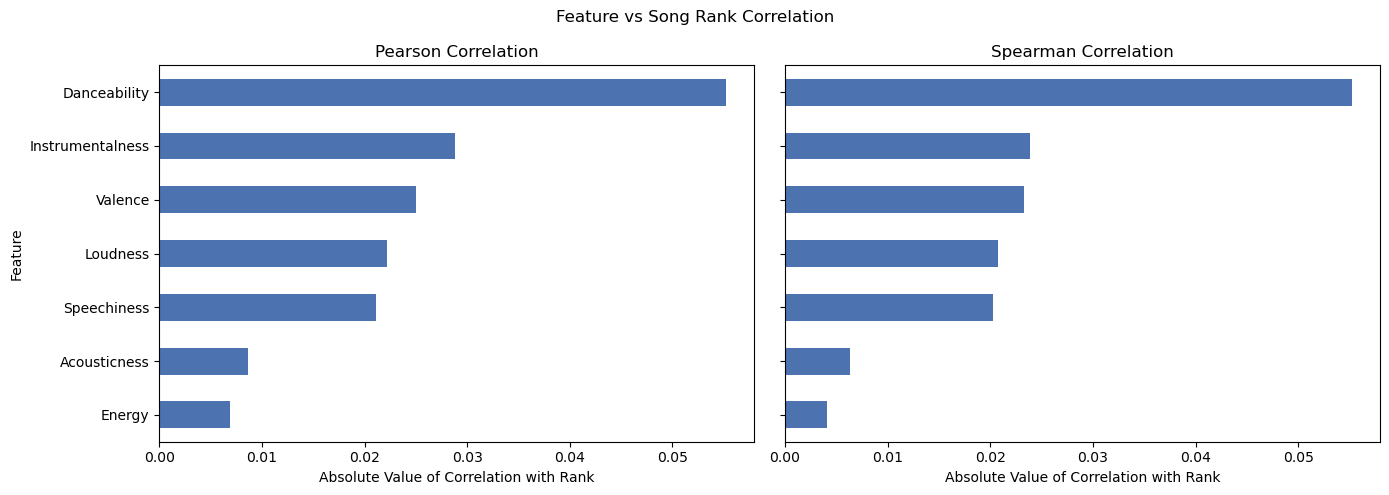

In [9]:
df_corr = dfMod[numerical_features + ["Rank"]].dropna()

# Rank-only correlations (exclude the trivial self-correlation)
pearson = df_corr.corr(method="pearson")["Rank"].drop("Rank")
spearman = df_corr.corr(method="spearman")["Rank"].drop("Rank")

# Plotting the magnitude of the correleation
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
for ax, values, title in zip(
    axes,
    [pearson.abs().sort_values(), spearman.abs().sort_values()],
    ["Pearson Correlation", "Spearman Correlation"]
):
    values.plot(kind="barh", ax=ax, color="#4c72b0")
    ax.set_xlabel("Absolute Value of Correlation with Rank")
    ax.set_ylabel("Feature")
    ax.set_title(title)

plt.suptitle("Feature vs Song Rank Correlation")
plt.tight_layout()
plt.savefig("correlation.pdf")
plt.show()

# Machine Learning Analysis with Data Tasks

### Task 1: Predicting the Rank of a given song, after training the model on N day Windows, to predict the N+1th day

How to formulate and solve the problem

1) We will use top 200 songs per day from a window size N to predict the top 200 songs of N+1th day

2) Look at the problem like follows:
    a) We will train on Data till 2022
    b) We will test on Data in 2023

How will training be?
    1) Make Pairs of X,Y for training, where

        X = (Day1[(Song1, Song2, Song3 ... Song200)],
             Day2[(Song1, Song2, Song3 ... Song200)],
                        .
                        .
                        .
             DayN[(Song1, Song2, Song3 ... Song200)])

        y = DayN+1[(Song1, Song2, Song3 ... Song200)]

    2) We do that to get the first X_1,Y_1 data pair
    3) To get the X_2, Y_2 data pair we do :

        X = (Day2[(Song1, Song2, Song3 ... Song200)],
             Day3[(Song1, Song2, Song3 ... Song200)],
                        .
                        .
                        .
             DayN+1[(Song1, Song2, Song3 ... Song200)])

        y = DayN+2[(Song1, Song2, Song3 ... Song200)]

    A.K.A, we move the sliding window by two.... and for Linear regression the number of weights we will train will be N*(200* (number of features per song))

    This is our training framework for sequential time series data like this, Once you implement this data split, its just matter of calling the functions I did below to train XgBoost , RandomForest and Linear Regression.

    THIS PROBLEM FORMULATION MAY WORK


#### Data Plotter for all Models

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_predictions(y_true, y_pred, model_name="Model"):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Scatter: True vs Pred
    axes[0].scatter(y_true, y_pred, alpha=0.3, edgecolor="none")
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    axes[0].plot(lims, lims, color="red", linewidth=1.5, label="Ideal")
    axes[0].set_title(f"{model_name}: True vs Predicted")
    axes[0].set_xlabel("True Rank")
    axes[0].set_ylabel("Predicted Rank")
    axes[0].legend()

    # Residuals histogram (True - Predicted)
    residuals = y_true - y_pred
    sns.histplot(residuals, bins=50, kde=True, ax=axes[1])
    axes[1].axvline(0, color="black", linewidth=1)
    axes[1].set_title(f"{model_name}: Residual Distribution")
    axes[1].set_xlabel("Residual (True - Predicted)")

    plt.tight_layout()
    plt.show()


def plot_double_residual_hist(y_true,
                              y_pred_lin,
                              y_pred_xgb,
                              labels=("Linear Regression", "XGBoost"),
                              window_size=None,
                              bins=80):

    res_lin = y_true - y_pred_lin
    res_xgb = y_true - y_pred_xgb
    std_lin = res_lin.std()
    std_xgb = res_xgb.std()

    all_res = np.concatenate([res_lin, res_xgb])
    rmin, rmax = all_res.min(), all_res.max()

    fig, axes = plt.plot(figsize=(12, 5))

    sns.histplot(
        res_lin,
        bins=bins,
        binrange=(rmin, rmax),
        stat="density",
        kde=True,
        alpha=0.6,
        label=f"{labels[0]} (std = {std_lin:.3f})",
        ax=axes
    )

    sns.histplot(
        res_xgb,
        bins=bins,
        binrange=(rmin, rmax),
        stat="density",
        kde=True,
        alpha=0.6,
        label=f"{labels[1]} (std = {std_xgb:.3f})",
        ax=axes
    )

    axes.axvline(0, color="black", linewidth=1)
    axes.set_xlabel("Residual (True - Predicted)")
    axes.set_ylabel("Density")
    axes.set_title(f"Residuals Comparison (Rolling, {window_size} days)")
    axes.legend()

    plt.tight_layout()
    plt.show()

def plot_double_residual_hist_traintest(y_true_train,
                              y_pred_train,
                              y_true_test,
                              y_pred_test,
                              labels=("Train", "Test"),
                              bins=80):

    res_train = y_true_train - y_pred_train
    res_test = y_true_test - y_pred_test
    std_lin = res_train.std()
    std_xgb = res_test.std()

    all_res = np.concatenate([res_train, res_test])
    rmin, rmax = all_res.min(), all_res.max()

    plt.plot(figsize=(12, 5))

    sns.histplot(
        res_train,
        bins=bins,
        binrange=(rmin, rmax),
        stat="density",
        kde=True,
        alpha=0.6,
        label=f"{labels[0]} (std = {std_lin:.3f})",
    )

    sns.histplot(
        res_test,
        bins=bins,
        binrange=(rmin, rmax),
        stat="density",
        kde=True,
        alpha=0.6,
        label=f"{labels[1]} (std = {std_xgb:.3f})",
    )

    axes.axvline(0, color="black", linewidth=1)
    axes.set_xlabel("Residual (True - Predicted)")
    axes.set_ylabel("Density")
    axes.set_title(f"Residuals Comparison (Train/Test split)")
    axes.legend()

    plt.tight_layout()
    plt.show()

### 30-day window model

#### Data Preparation

In [11]:
# Global sort once
dfMod.sort_values(by=["Date", "Rank"], ascending=[True, True], inplace=True)

# Add features ONCE
dfMod = add_weighted_endurance(dfMod)
dfMod = add_ranking_derivative(dfMod)

features_to_use = custom_features + numerical_features + date_features
target_col = "Rank"

unique_dates = dfMod["Date"].sort_values().unique()
WINDOW_SIZE = 90

#### Refactored Code for training the window model: rolling_train

In [12]:
def rolling_train(model_ctor, model_name, save_dir="./saved_models"):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    all_true_vals = []
    all_preds = []

    total_iters = len(unique_dates)

    for idx in tqdm(range(WINDOW_SIZE, total_iters)):
        from_date = unique_dates[idx - WINDOW_SIZE]
        to_date   = unique_dates[idx - 1]
        test_day  = unique_dates[idx]

        # Dataset
        df_train = dfMod[(dfMod["Date"] >= from_date) & (dfMod["Date"] <= to_date)].copy()
        df_test  = dfMod[dfMod["Date"] == test_day].copy()

        df_train, weights_dict = add_artist_weights(df_train)
        df_test, _             = add_artist_weights(df_test)

        # Data to feed model
        X_train = df_train[features_to_use]
        y_train = df_train[target_col]

        X_test  = df_test[features_to_use]
        y_test  = df_test[target_col]

        model = model_ctor()
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        all_true_vals.append(y_test.values)
        all_preds.append(y_pred)

    all_true_vals = np.concatenate(all_true_vals)
    all_preds     = np.concatenate(all_preds)

    rmse_val = np.sqrt(mean_squared_error(all_true_vals, all_preds))
    results_data = {
        "model_name": model_name,
        "rmse": rmse_val,
        "Y_true_all": all_true_vals,
        "Y_pred_all": all_preds,
        "window_size": WINDOW_SIZE,
        "features_used": features_to_use,
    }

    with open(os.path.join(save_dir, f"final_results_{model_name}.pkl"), "wb") as f_out:
        pickle.dump(results_data, f_out)

    print(f"\nOutputs saved to folder: {save_dir}")

    plot_predictions(all_true_vals, all_preds,
                     model_name=f"{model_name} (Rolling, {WINDOW_SIZE} days)")

    return all_true_vals, all_preds, WINDOW_SIZE

### Lin Reression and XGBoost

In [ ]:
Y_true_all=[]
Y_pred_lin_all=[]
Y_pred_xgb_all=[]

for i in tqdm(range(WINDOW_SIZE, len(unique_dates))):
    train_start=unique_dates[i - WINDOW_SIZE]
    train_end=unique_dates[i - 1]
    test_date=unique_dates[i]

    # Select rows
    Train = dfMod[
        (dfMod["Date"]>=train_start) &
        (dfMod["Date"]<=train_end)
    ]

    Test=dfMod[dfMod["Date"] == test_date]

    # Artist weights per window
    Train, dict_artist_vals=add_artist_weights(Train)
    Test=add_artist_weights(Test, False, dict_artist_vals)

    # Use features directly (NO scaler)
    X_Train=Train[features_to_use]
    Y_Train=Train[target_col]

    X_Test=Test[features_to_use]
    Y_Test=Test[target_col]

    # Linear Regression
    lin_reg=LinearRegression()
    lin_reg.fit(X_Train, Y_Train)
    Y_Pred_Test_lin=lin_reg.predict(X_Test)

    # XGBoost
    xgb_reg=XGBRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=7,
        subsample=0.9,
        colsample_bytree=0.9,
        objective="reg:squarederror",
        tree_method="hist",
        random_state=42,
        n_jobs=-1
    )
    xgb_reg.fit(X_Train, Y_Train)
    Y_Pred_Test_xgb=xgb_reg.predict(X_Test)

    Y_true_all.append(Y_Test.values)
    Y_pred_lin_all.append(Y_Pred_Test_lin)
    Y_pred_xgb_all.append(Y_Pred_Test_xgb)

Y_true_all=np.concatenate(Y_true_all)
Y_pred_lin_all=np.concatenate(Y_pred_lin_all)
Y_pred_xgb_all=np.concatenate(Y_pred_xgb_all)

print("MOVING WINDOW STATISTICS")
print(f"Linear Regression RMSE: {np.sqrt(mean_squared_error(Y_true_all, Y_pred_lin_all)):.4f}")
print(f"XGBoost RMSE: {np.sqrt(mean_squared_error(Y_true_all, Y_pred_xgb_all)):.4f}")

# Save data
os.makedirs("model_results", exist_ok=True)

filename=f"results_window{WINDOW_SIZE}.npz"
filepath=os.path.join("model_results", filename)

np.savez_compressed(
    filepath,
    y_true=Y_true_all,
    y_pred_lin=Y_pred_lin_all,
    y_pred_xgb=Y_pred_xgb_all,
    window_size=WINDOW_SIZE,
    features_used=np.array(features_to_use),
)

print(f"\nSaved rolling-window results to: {filepath}")

In [ ]:
# Separate cell that imports data to avoid executing the long simulation multiple times

data = np.load("model_results/results_window90.npz")

Y_true_all     = data["y_true"]
Y_pred_lin_all = data["y_pred_lin"]
Y_pred_xgb_all = data["y_pred_xgb"]

plot_predictions(Y_true_all, Y_pred_lin_all,
                 model_name=f"Linear Regression (Rolling, {WINDOW_SIZE} days)")
plot_predictions(Y_true_all, Y_pred_xgb_all,
                 model_name=f"XGBoost (Rolling, {WINDOW_SIZE} days)")
plot_double_residual_hist(Y_true_all, Y_pred_lin_all, Y_pred_xgb_all, window_size=WINDOW_SIZE)

### Test/Train split

In [14]:
# Sort by Date and Rank
dfMod.sort_values(by=["Date", "Rank"], ascending=[True, True], inplace=True)
dfMod = add_weighted_endurance(dfMod)

train_end = pd.to_datetime("30/06/2022", format="%d/%m/%Y")
val_end = pd.to_datetime("31/12/2022", format="%d/%m/%Y")

Train = dfMod.loc[(dfMod['Date'] <= train_end)]
Val = dfMod.loc[(dfMod['Date'] > train_end) & (dfMod['Date'] <= val_end)]
Test = dfMod.loc[(dfMod['Date'] > val_end)]

# Adding Artist Weights 
Train, dict_artist_vals = add_artist_weights(Train)
Val = add_artist_weights(Val, False, dict_artist_vals)
Test = add_artist_weights(Test, False,dict_artist_vals)

# Fitting Standard Scalar 
# Thought: Will fitting standard scalar also scale down the artist weights correctly?

scaler = StandardScaler()
Train_scaled = Train.copy()
Val_scaled = Val.copy()
Test_scaled = Test.copy()

features_to_scale = custom_features + numerical_features

Train_scaled[features_to_scale] = scaler.fit_transform(Train[features_to_scale] ) 
Val_scaled[features_to_scale] = scaler.transform(Val[features_to_scale])
Test_scaled[features_to_scale] = scaler.transform(Test[features_to_scale])

# Final Training and Target Data speration
X_Train, X_Val, X_Test = Train_scaled[features_to_scale + date_features],Val_scaled[features_to_scale + date_features] , Test_scaled[features_to_scale + date_features]
Y_Train, Y_Val, Y_Test = Train_scaled["Rank"], Val_scaled["Rank"], Test_scaled["Rank"]

In [15]:
# LR
lin_reg = LinearRegression()
lin_reg.fit(X_Train, Y_Train)

Y_Pred_Train = lin_reg.predict(X_Train)
Y_Pred_Val   = lin_reg.predict(X_Val)
Y_Pred_Test  = lin_reg.predict(X_Test)

print("TRAINING STATISTICS")
print(f"Train RMSE: {np.sqrt(mean_squared_error(Y_Train, Y_Pred_Train)):.4f}")
print(f"Val RMSE: {np.sqrt(mean_squared_error(Y_Val, Y_Pred_Val)):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(Y_Test, Y_Pred_Test)):.4f}")

# Save data
os.makedirs("model_results", exist_ok=True)

filename = f"results_traintest_LR.npz"
filepath = os.path.join("model_results", filename)

np.savez_compressed(
    filepath,
    y_true_train=Y_Train,
    y_true_test=Y_Test,
    y_pred_train=Y_Pred_Train,
    y_pred_test=Y_Pred_Test
)

print(f"\nSaved train/test split results to: {filepath}")

********TRAINING STATISTICS**********
Train RMSE: 56.0162
Val   RMSE: 56.8292
Test  RMSE: 58.1646

Saved train/test split results to: model_results\results_traintest_LR.npz


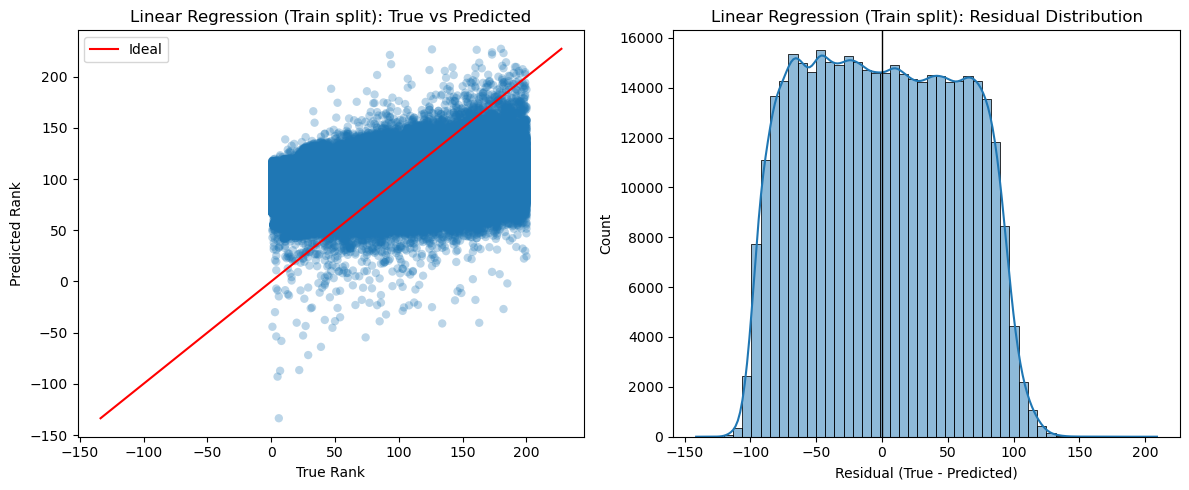

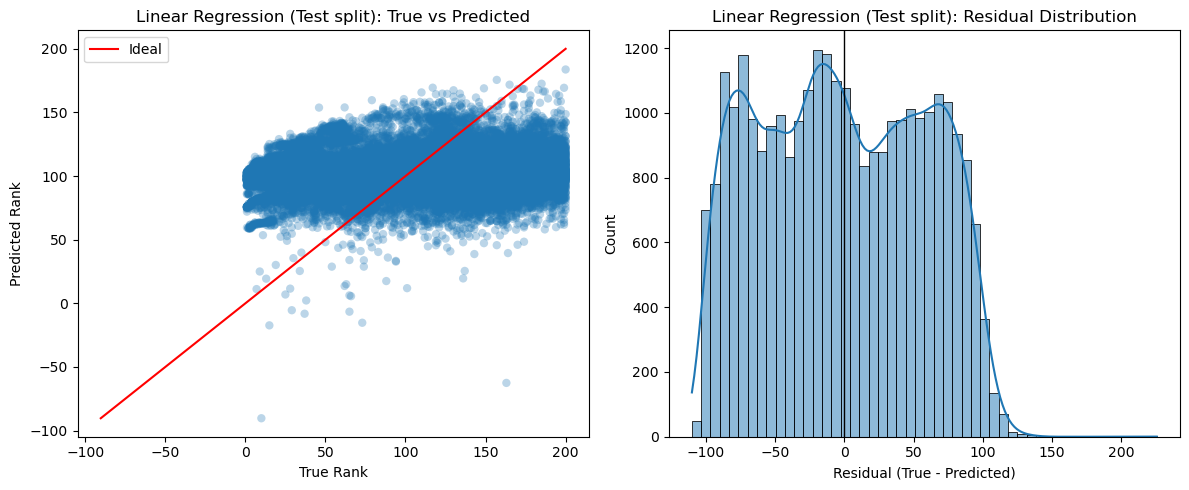

AttributeError: 'numpy.ndarray' object has no attribute 'axvline'

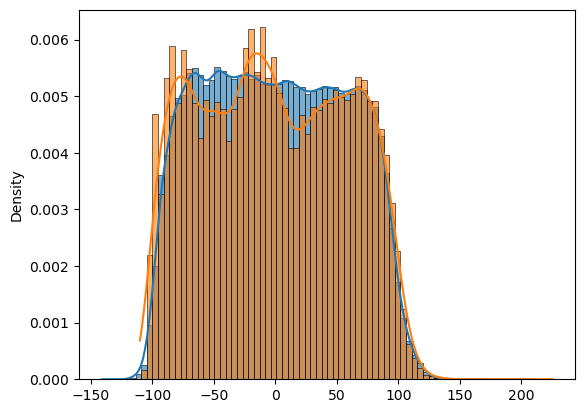

In [19]:
# Separate cell that imports data to avoid executing the long simulation multiple times

data = np.load("model_results/results_traintest_LR.npz")

Y_true_train = data["y_true_train"]
Y_pred_train = data["y_pred_train"]
Y_true_test = data["y_true_test"]
Y_pred_test = data["y_pred_test"]

plot_predictions(Y_true_train, Y_pred_train,
                 model_name=f"Linear Regression (Train split)")
plot_predictions(Y_true_test, Y_pred_test,
                 model_name=f"Linear Regression (Test split)")

plot_double_residual_hist_traintest(Y_true_train, Y_pred_train, Y_true_test, Y_pred_test)

In [ ]:
# XGB
xgb_reg = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="reg:squarederror",
    tree_method="hist",
    random_state=42,
    n_jobs=-1
)
xgb_reg.fit(X_Train, Y_Train)

Y_Pred_Train_XGB = xgb_reg.predict(X_Train)
Y_Pred_Val_XGB = xgb_reg.predict(X_Val)
Y_Pred_Test_XGB = xgb_reg.predict(X_Test)

print("XGBOOST STATISTICS")
print(f"Train RMSE: {np.sqrt(mean_squared_error(Y_Train, Y_Pred_Train_XGB)):.4f}")
print(f"Val RMSE: {np.sqrt(mean_squared_error(Y_Val, Y_Pred_Val_XGB)):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(Y_Test, Y_Pred_Test_XGB)):.4f}")

# Save data
os.makedirs("model_results", exist_ok=True)

filename = f"results_traintest_XGB.npz"
filepath = os.path.join("model_results", filename)

np.savez_compressed(
    filepath,
    y_true_train=Y_Train,
    y_true_test=Y_Test,
    y_pred_train=Y_Pred_Train,
    y_pred_test=Y_Pred_Test
)

print(f"\nSaved train/test split results to: {filepath}")

In [ ]:
# Separate cell that imports data to avoid executing the long simulation multiple times

data = np.load("model_results/results_traintest_XGB.npz")

Y_true_train = data["y_true_train"]
Y_pred_train = data["y_pred_train"]
Y_true_test = data["y_true_test"]
Y_pred_test = data["y_pred_test"]

plot_predictions(Y_true_train, Y_pred_train,
                 model_name=f"XGBoost (Train split)")
plot_predictions(Y_true_test, Y_pred_test,
                 model_name=f"XGBoost (Test split)")

plot_double_residual_hist_traintest(Y_true_train, Y_pred_train, Y_true_test, Y_pred_test)

### Pytorch check

In [ ]:
# 1. Basic check
print("CUDA available:", torch.cuda.is_available())
print("Current device:", torch.cuda.current_device() if torch.cuda.is_available() else "CPU only")
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "N/A")

CUDA available: True
Current device: 0
Device name: NVIDIA L4


### Multi Layer Regressor

In [ ]:
class MLPRegressorTorch(nn.Module):
    def __init__(self, input_dim, hidden_sizes):
        super().__init__()
        layers = []
        in_features = input_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(in_features, h))
            layers.append(nn.ReLU())
            in_features = h
        layers.append(nn.Linear(in_features, 1))  # Output layer for regression
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x).squeeze(-1)  # Squeeze output to 1D

In [ ]:
class MLPRegressorWrapper:
    def __init__(
        self,
        input_dim,
        hidden_sizes=(1024, 512, 256),
        epochs=25,
        batch_size=1024,
        lr=1e-3,
    ):
        self.input_dim=input_dim
        self.hidden_sizes=hidden_sizes
        self.epochs=epochs
        self.batch_size=batch_size
        self.lr=lr

        self.device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model=MLPRegressorTorch(input_dim, hidden_sizes).to(self.device)

        # simple scaler so no features dominate
        self.scaler = StandardScaler()

    def _prepare_xy(self, X, y=None, fit_scaler=False):
        if hasattr(X, "values"):
            X = X.values
        X = np.asarray(X, dtype=np.float32)

        if fit_scaler:
            X=self.scaler.fit_transform(X)
        else:
            X=self.scaler.transform(X)

        X_tensor=torch.as_tensor(X, dtype=torch.float32)
        if y is None:
            return X_tensor

        if hasattr(y, "values"):
            y=y.values
        y_tensor=torch.as_tensor(y, dtype=torch.float32)
        return X_tensor, y_tensor

    def fit(self, X, y):
        if len(X) == 0:
            return self

        X_tensor, y_tensor=self._prepare_xy(X, y, fit_scaler=True)
        effective_bs=min(self.batch_size, len(X_tensor))

        dataset=torch.utils.data.TensorDataset(X_tensor, y_tensor)
        loader=torch.utils.data.DataLoader(
            dataset,
            batch_size=effective_bs,
            shuffle=True,
            pin_memory=True,
            num_workers=2,
            drop_last=False,
        )

        criterion=nn.MSELoss()
        optimizer=optim.Adam(self.model.parameters(), lr=self.lr)

        self.model.train()
        for epoch in range(self.epochs):
            for xb, yb in loader:
                xb=xb.to(self.device, non_blocking=True)
                yb=yb.to(self.device, non_blocking=True)

                optimizer.zero_grad(set_to_none=True)
                preds = self.model(xb)
                loss = criterion(preds, yb)
                loss.backward()
                # Prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                optimizer.step()

        return self

    def predict(self, X):
        if len(X) == 0:
            return np.array([])

        X_tensor = self._prepare_xy(X, fit_scaler=False)
        self.model.eval()

        preds = []
        # Use larger batches for inference since we're not computing gradients
        batch_size = min(self.batch_size * 2, len(X_tensor))
        with torch.no_grad():
            for i in range(0, len(X_tensor), batch_size):
                batch = X_tensor[i:i + batch_size].to(self.device, non_blocking=True)
                preds.append(self.model(batch).cpu().numpy())

        return np.concatenate(preds) if preds else np.array([])

In [18]:
# Exactly same code as for LR and XGB but for MLPReg

Y_true_all = []
Y_pred_mlp_all = []

for i in tqdm(range(WINDOW_SIZE, len(unique_dates))):
    train_start = unique_dates[i - WINDOW_SIZE]
    train_end   = unique_dates[i - 1]
    test_date   = unique_dates[i]

    # Select rows
    Train = dfMod[
        (dfMod["Date"] >= train_start) &
        (dfMod["Date"] <= train_end)
    ]

    Test = dfMod[dfMod["Date"] == test_date]

    # Artist weights per window
    Train, dict_artist_vals = add_artist_weights(Train)
    Test = add_artist_weights(Test, False, dict_artist_vals)

    # Use features directly
    X_Train = Train[features_to_use]
    Y_Train = Train[target_col]

    X_Test  = Test[features_to_use]
    Y_Test  = Test[target_col]

    input_dim = len(features_to_use)
    mlp_reg = MLPRegressorWrapper(input_dim=input_dim)

    mlp_reg.fit(X_Train, Y_Train)
    Y_Pred_Test_mlp = mlp_reg.predict(X_Test)

    Y_true_all.append(Y_Test.values)
    Y_pred_mlp_all.append(Y_Pred_Test_mlp)

Y_true_all    = np.concatenate(Y_true_all)
Y_pred_mlp_all = np.concatenate(Y_pred_mlp_all)

print("MLP REGRESSOR STATISTICS")
rmse_mlp = np.sqrt(np.mean((Y_true_all - Y_pred_mlp_all)**2))
print(f"MLP RMSE: {rmse_mlp:.4f}")

# Save data
os.makedirs("model_results", exist_ok=True)

filename = f"results_mlp_window{WINDOW_SIZE}.npz"
filepath = os.path.join("model_results", filename)

np.savez_compressed(
    filepath,
    y_true=Y_true_all,
    y_pred_mlp=Y_pred_mlp_all,
    window_size=WINDOW_SIZE,
    features_used=np.array(features_to_use),
)

print(f"\nSaved rolling-window results to: {filepath}")

  0%|          | 0/2246 [00:00<?, ?it/s]


NameError: name 'MLPRegressorWrapper' is not defined

In [ ]:
# Separate cell that imports data to avoid executing the long simulation multiple times

data = np.load("model_results/results_mlp_window90.npz")

Y_true_all = data["y_true"]
Y_pred_mlp = data["y_pred_mlp"]

plot_predictions(Y_true_all, Y_pred_lin_all,
                 model_name=f"MLP Regressor (Rolling, {WINDOW_SIZE} days)")

### LSTM

##### Defining Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# Sequence builders

def _pad_history(history, seq_length, fill_vec):

    """
    Makes sure we always have exactly seq_length timesteps.
    If we don't have enough history yet, repeat the earliest values.
    """

    if history.shape[0] == seq_length:
        return history.astype(np.float32)
    # No history at all fill everything with the fallback vector
    if history.shape[0] == 0:
        pad = np.repeat(fill_vec[None, :], seq_length, axis=0)
        return pad.astype(np.float32)
    pad = np.repeat(history[0:1], seq_length - history.shape[0], axis=0)
    return np.vstack([pad, history]).astype(np.float32)


def build_train_sequences(df, features, target_col, seq_length):
    sequences, deltas = [], []
    df = df.sort_values(["Title", "Date"])

    for _, grp in df.groupby("Title"):
        grp = grp.sort_values("Date")
        feat = grp[features].values
        tgt = grp[target_col].values


        # Start from index 1 since we need at least one previous observation
        for j in range(1, len(grp)):
            history = feat[max(0, j - seq_length):j]
            fill_vec = feat[j - 1]
            seq = _pad_history(history, seq_length, fill_vec)
            delta = tgt[j] - tgt[j - 1]
            sequences.append(seq)
            deltas.append(delta)

    if not sequences:
        return np.empty((0, seq_length, len(features)), dtype=np.float32), np.empty((0,), dtype=np.float32)

    return np.stack(sequences).astype(np.float32), np.array(deltas, dtype=np.float32)


def build_test_sequences(train_df, test_df, features, target_col, seq_length):
    sequences, idx_list, base_ranks = [], [], []
    combo = pd.concat([train_df, test_df]).sort_values(["Title", "Date"])

    for _, grp in combo.groupby("Title"):
        grp = grp.sort_values("Date")
        feat = grp[features].values
        tgt = grp[target_col].values
        rows = grp.index.values

        # Only include rows that are actually in the test set
        for j in range(1, len(grp)):
            row_id = rows[j]
            if row_id not in test_df.index:
                continue
            history = feat[max(0, j - seq_length):j]
            fill_vec = feat[j - 1]
            seq = _pad_history(history, seq_length, fill_vec)

            sequences.append(seq)
            idx_list.append(row_id)
            # Save the previous rank so we can add our predicted change to it
            base_ranks.append(tgt[j - 1])

    if not sequences:
        return np.empty((0, seq_length, len(features)), dtype=np.float32), [], []

    return (
        np.stack(sequences).astype(np.float32),
        idx_list,
        np.array(base_ranks, dtype=np.float32),
    )

# LSTM wrapper

class SequenceLSTMWrapper:
    def __init__(
        self,
        input_dim,
        seq_length,
        hidden_dim=128,
        num_layers=2,
        dropout=0.3,
        epochs=30,
        batch_size=1024,
        lr=1e-3,
        patience=4,
        min_delta=1e-3,
    ):
        self.input_dim = input_dim
        self.seq_length = seq_length
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.patience = patience
        self.min_delta = min_delta

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.scaler = StandardScaler()


        # Main LSTM processes the sequence
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True,
        ).to(self.device)

        # Small network on top to produce final prediction
        self.head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim//2, 1),
        ).to(self.device)

    def _scale(self, X, fit=False):
        """Scale features across all timesteps to prevent any one feature dominating."""
        if len(X) == 0:
            return X
        n, l, f = X.shape

        # Flatten to 2D, scale, then reshape back
        X_flat = X.reshape(-1, f)
        X_flat = self.scaler.fit_transform(X_flat) if fit else self.scaler.transform(X_flat)
        return X_flat.reshape(n, l, f)

    def fit(self, X_seq, y):
        if len(X_seq) == 0:
            return self

        X_seq = self._scale(X_seq, fit=True)
        X_tensor = torch.as_tensor(X_seq, dtype=torch.float32)
        y_tensor = torch.as_tensor(y, dtype=torch.float32)

        dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
        loader = torch.utils.data.DataLoader(
            dataset,
            batch_size=min(self.batch_size, len(dataset)),
            shuffle=True,
            pin_memory=True,
            num_workers=2,
            drop_last=False,
        )

        params = list(self.lstm.parameters()) + list(self.head.parameters())
        optimizer = optim.Adam(params, lr=self.lr)
        criterion = nn.MSELoss()

        self.lstm.train()
        self.head.train()
        # Stop it early to avoid overfitting
        best_loss = float("inf")
        patience_left = self.patience

        for epoch in range(self.epochs):
            epoch_loss = 0.0
            batches = 0

            for xb, yb in loader:
                xb = xb.to(self.device, non_blocking=True)
                yb = yb.to(self.device, non_blocking=True)

                optimizer.zero_grad(set_to_none=True)
                # LSTM processes sequence, we use the final hidden state
                lstm_out, _ = self.lstm(xb)
                preds = self.head(lstm_out[:, -1, :]).squeeze(-1)
                loss = criterion(preds, yb)

                loss.backward()
                torch.nn.utils.clip_grad_norm_(params, 1.0)
                optimizer.step()

                epoch_loss += loss.item()
                batches += 1

            epoch_loss /= max(batches, 1)

            if epoch_loss + self.min_delta < best_loss:
                best_loss = epoch_loss
                patience_left = self.patience
            else:
                patience_left -= 1
                if patience_left == 0:
                    break

        return self

    def predict(self, X_seq):
        if len(X_seq) == 0:
            return np.array([])

        X_seq = self._scale(X_seq, fit=False)
        X_tensor = torch.as_tensor(X_seq, dtype=torch.float32)

        self.lstm.eval()
        self.head.eval()

        outputs = []
        batch_size = min(self.batch_size * 2, len(X_tensor))
        with torch.no_grad():
            for i in range(0, len(X_tensor), batch_size):
                batch = X_tensor[i:i + batch_size].to(self.device, non_blocking=True)
                lstm_out, _ = self.lstm(batch)
                outputs.append(self.head(lstm_out[:, -1, :]).squeeze(-1).cpu().numpy())

        return np.concatenate(outputs) if outputs else np.array([])

# Rolling loop (safe against NaNs)

def rolling_train_sequence_lstm(model_ctor, model_name, seq_length=WINDOW_SIZE):
    Y_true_all = []
    Y_pred_all = []

    for i in tqdm(range(WINDOW_SIZE+1000, 1600)):
        train_start = unique_dates[i - WINDOW_SIZE]
        train_end   = unique_dates[i - 1]
        test_date   = unique_dates[i]

        Train = dfMod[(dfMod["Date"] >= train_start) & (dfMod["Date"] <= train_end)].copy()
        Test  = dfMod[dfMod["Date"] == test_date].copy()

        # drop rows with missing features/targets that already exist
        drop_cols = [c for c in features_to_use + [target_col] if c in Train.columns]
        Train = Train.dropna(subset=drop_cols)
        Test  = Test.dropna(subset=drop_cols)
        if len(Train) == 0 or len(Test) == 0:
            continue

        Train, dict_artist_vals = add_artist_weights(Train)
        Test = add_artist_weights(Test, False, dict_artist_vals)

        # now all columns in features_to_use exist; drop any new NaNs
        Train = Train.dropna(subset=features_to_use + [target_col])
        Test  = Test.dropna(subset=features_to_use + [target_col])
        if len(Train) == 0 or len(Test) == 0:
            continue

        X_train_seq, y_train = build_train_sequences(Train, features_to_use, target_col, seq_length)
        X_test_seq, test_idx, base_ranks = build_test_sequences(Train, Test, features_to_use, target_col, seq_length)

        if len(X_train_seq) == 0 or len(X_test_seq) == 0:
            continue

        model = model_ctor(input_dim=len(features_to_use), seq_length=seq_length)
        model.fit(X_train_seq, y_train)

        delta_pred = model.predict(X_test_seq)
        preds = np.clip(base_ranks + delta_pred, 1, 200)
        
        # Line up predictions with actual test rows
        aligned = Test.loc[test_idx]
        mask = np.isfinite(preds)
        if not np.all(mask):
            preds = preds[mask]
            aligned = aligned.iloc[np.nonzero(mask)[0]]
        if len(aligned) == 0:
            continue

        Y_true_all.append(aligned[target_col].values)
        Y_pred_all.append(preds)

    if not Y_true_all:
        raise RuntimeError("No sequences were built. Lower seq_length or inspect data coverage.")

    Y_true_all = np.concatenate(Y_true_all)
    Y_pred_all = np.concatenate(Y_pred_all)

    rmse = np.sqrt(mean_squared_error(Y_true_all, Y_pred_all))
    print(f"{model_name.upper()} (SEQ-LSTM, ROLLING {seq_length} DAYS)")
    print(f"{model_name} RMSE: {rmse:.4f}")
    plot_predictions(
        Y_true_all,
        Y_pred_all,
        model_name=f"{model_name} Seq-LSTM (Rolling {seq_length} days)"
    )
    return rmse, Y_true_all, Y_pred_all

##### Training Model

100%|██████████| 110/110 [39:02<00:00, 21.30s/it]


********SEQUENCE LSTM (SEQ-LSTM, ROLLING 90 DAYS)********
Sequence LSTM RMSE: 13.2209


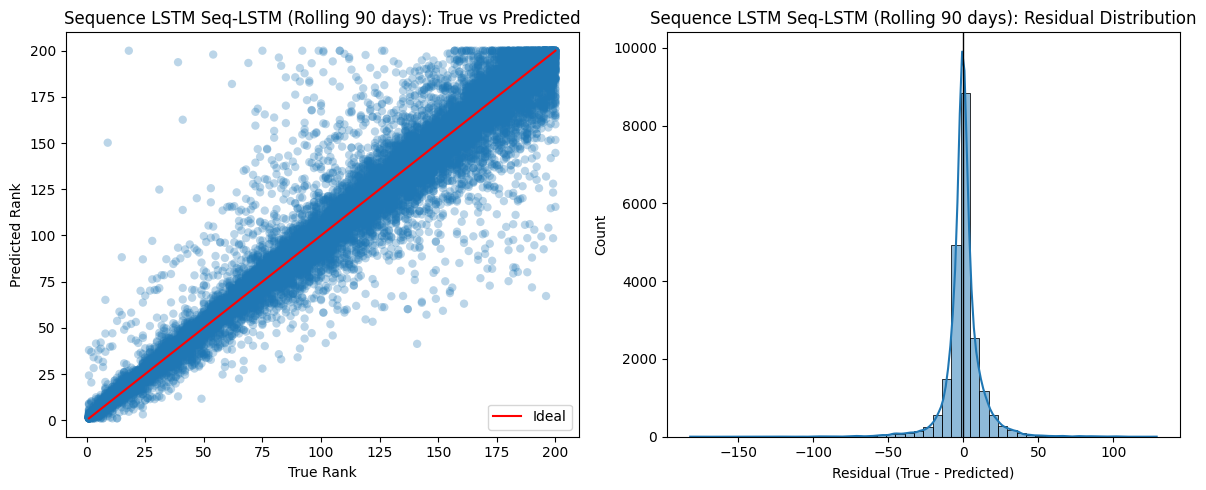

In [ ]:
seq_rmse, y_true_seq, y_pred_seq = rolling_train_sequence_lstm(
    model_ctor=lambda **kw: SequenceLSTMWrapper(
        hidden_dim=128,
        num_layers=2,
        dropout=0.3,
        epochs=35,
        batch_size=2048,
        lr=1e-3,
        **kw,
    ),
    model_name="Sequence LSTM",
    seq_length=90,
)

In [ ]:
# Trying with 600 days now

100%|██████████| 510/510 [3:20:34<00:00, 23.60s/it]


********SEQUENCE LSTM (SEQ-LSTM, ROLLING 90 DAYS)********
Sequence LSTM RMSE: 14.2147


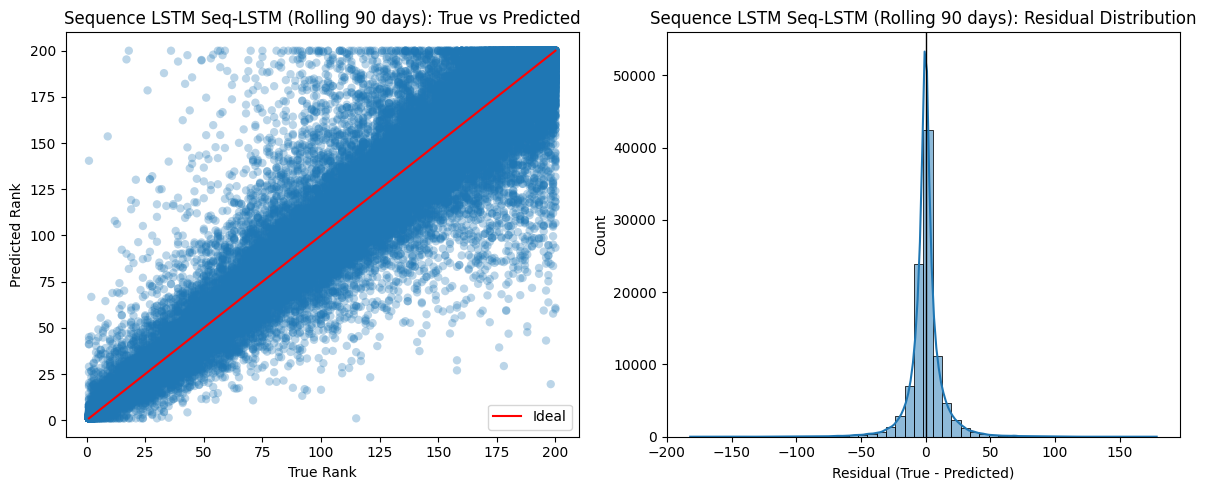

In [ ]:
seq_rmse, y_true_seq, y_pred_seq = rolling_train_sequence_lstm(
    model_ctor=lambda **kw: SequenceLSTMWrapper(
        hidden_dim=128,
        num_layers=2,
        dropout=0.3,
        epochs=35,
        batch_size=2048,
        lr=1e-3,
        **kw,
    ),
    model_name="Sequence LSTM",
    seq_length=90,
)